# Multivariante Kalman Filter
In general, the Kalman filter can be represented in the following matrix form: ($\boldsymbol{R}$ is the measurement covariance matrix)

Predict
Predicted state estimate	

\begin{equation}{\hat{\boldsymbol {x}}}_{k|k-1}=f({\hat {\boldsymbol {x}}}_{k-1|k-1},{\boldsymbol {u}}_{k-1})
\end{equation}
Predicted covariance estimate	

\begin{equation} \boldsymbol {P}_{k|k-1}={{\boldsymbol {F}}_{k}}{\boldsymbol {P}}_{k-1|k-1}{{\boldsymbol {F}}_{k}^{T}}+{\boldsymbol {Q}}_{k-1} 
\end{equation}

Update
Innovation or measurement residual	
\begin{equation}
  \tilde{\boldsymbol{y}}_{k}=\boldsymbol{z}_{k} - h({\hat{{\boldsymbol{x}}}}_{{k|k-1}}) \end{equation}
  
Near-optimal Kalman gain
\begin{equation}
\boldsymbol {K}_{k}=\boldsymbol{P}_{k|k-1} \boldsymbol {H}_{k}^{T} \Big(\boldsymbol{H}\boldsymbol{P}\boldsymbol{H}^T + \boldsymbol{R}\Big)^{-1}
\end{equation}

Updated state estimate	
\begin{equation}
\hat{\boldsymbol{x}_{k|k}}=\hat{\boldsymbol{x}}_{k|k-1} + \boldsymbol{K}_{k} \tilde{\boldsymbol{y}}_{k}
\end{equation}

Updated covariance estimate	
\begin{equation} \boldsymbol{P}_{k|k}=( \boldsymbol{I}- \boldsymbol{K}_{k} \boldsymbol{H}_{k})\boldsymbol{P}_{k|k-1}
\end{equation}

where $\boldsymbol{F}$ and $\boldsymbol{H}$ are the Jacobian matrix for $f$ and $h$

# Construction of state transition model

Consider the simplest example, where we are trying to construct the state transition model of a moving aircraft travelling at constant velocity. We can easily write down the 1st order ODE
\begin{align}
\dot{x}_n &= v
\end{align}

To convert the linear ODE into a state transition model, we perform integration to the above equation. For discrete case, we perform forward Euler discretization to the equation. 
\begin{align}
\frac{x_n - x_{n-1}}{\Delta t} &= v \\
x_n &= x_{n-1} + v\Delta t\\
\dot{x}_n &= \dot{x}_{n-1} \\
\end{align}

If we only want to estimate the position, we can use $x_n = x_{n-1} + v\Delta t$ as the state transition matrix in the 1D Kalman filter, and our job is done. If the initial velocity is also unknown to us, we can infer the velocity using the same method by making the velocity as one of the state variables. Rewrite the transition equation into matrix form and we obtained:
\begin{align}
\boldsymbol{x}_n = \begin{bmatrix}x_n \\ \dot{x}_n \end{bmatrix} = \begin{bmatrix} 1 & \Delta t \\ 0 & 1 \end{bmatrix} \begin{bmatrix}x_{n-1} \\ \dot{x}_{n-1} \end{bmatrix} = \boldsymbol{F}\boldsymbol{x}_{n-1}
\end{align}


Text(0, 0.5, 'velocity')

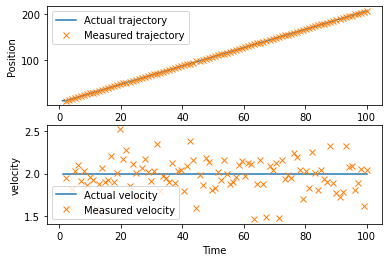

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def gen_data(x0, v0, count, noise = 0, accel=0.):
    #generate data given the initial state, velocity, acceleration and noise 
    xs = [x0]
    vs = [v0]
    zs1 = []
    zs2 = []
    for i in range(count):
        xs.append(x0 + accel * (i**2) / 2 + v0*i)
        zs1.append(x0 + accel * (i**2) / 2 + v0*i + noise*np.random.randn())
        vs.append(v0 + accel)
        zs2.append(v0 + accel + noise*np.random.randn())
    zs = np.array([zs1, 
                  zs2], dtype='float')
    true = np.array([xs,
                     vs], dtype='float')
    return true, zs

x0 = 10
v0 = 2
count = 100
dt = 1
var = 0.2
time = np.linspace(1, count, count+1)
xs, zs = gen_data(x0, v0, count, noise = var)

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(time, xs[0], '-', label = 'Actual trajectory')
ax1.plot(time[1:], zs[0], 'x', label = 'Measured trajectory')
ax1.legend()
ax1.set_xlabel('Time')
ax1.set_ylabel('Position')

ax2.plot(time, xs[1], '-', label = 'Actual velocity')
ax2.plot(time[1:], zs[1], 'x', label = 'Measured velocity')
ax2.legend()
ax2.set_xlabel('Time')
ax2.set_ylabel('velocity')

mean p 2.01, variance of p 0.15


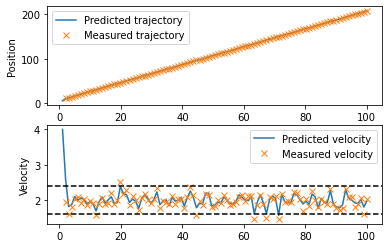

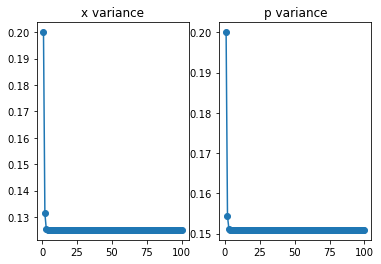

In [2]:
from numpy.linalg import inv
import math
def predict(x, P, Q):  
    dt = 1
    F = np.array([[1, dt],
                  [0, 1],
                 ], dtype='float') 
    
    #predict covariance
    P = F @ P @ F.T + Q
    
    x = F @ x
    return x, P

def update(x, P, H, R, z):
    S = H @ P @ H.T + R
    K = P @ H.T @ inv(S) #kalman gain
    y = z - H @ x #innovation 
    x += K @ y   #update state based on prior
    P = P - K @ H @ P #update covariance based on prior
    return x, P, K

def EKF(x, P, Q, H, R, z):
    x_list, P_list, K_list =  [x[:,0]], [P], []
    for item in range(z.shape[1]):
        x, P = predict(x, P, Q)
        #transform z into a column vector
        z_t = z[:, item].reshape([z.shape[0],1])
        x, P, K = update(x, P, H, R, z_t)
        x_list.append(x[:,0])
        P_list.append(P)
        K_list.append(K)
    return x_list, P_list, K_list

Q = np.array([[(dt**3)/3, (dt**2)/2],
                          [(dt**2)/2, dt]
                          ],  dtype='float') #process noise

H = np.array([[1, 0],
              [0, 1]], dtype = 'float')

R = var*np.array([[1,0],
              [0, 1]], dtype='float')

P = var*np.array([[1,0],
              [0,1]], dtype ='float') #variance initial guess 

x = np.array([[5],
             [4]]) #state space initial guess

x_list, P_list, K_list = EKF(x,P,Q, H,R,zs)
#print(x_list)
x_arr = np.array(x_list)
P_arr = np.array(P_list)
#K_arr = np.array(K_list)
#print(P_arr)
#print(P_arr[:,0,0])
fig2, (ax3, ax4) = plt.subplots(2)
ax3.plot(time, x_arr[:,0], '-', label = 'Predicted trajectory')
ax3.plot(time[1:], zs[0], 'x', label = 'Measured trajectory')
ax3.legend()
ax3.set_ylabel('Position')
ax4.plot(time, x_arr[:,1], '-', label = 'Predicted velocity')
ax4.plot(time[1:], zs[1], 'x', label = 'Measured velocity')
ax4.legend()
ax4.set_ylabel('Velocity')

fig3, (ax_covx, ax_covp) = plt.subplots(1,2)
ax_covx.plot(time, P_arr[:,0,0], '-o', label = 'x Variance')
ax_covp.plot(time, P_arr[:,1,1], '-o', label = 'p variance')
ax_covx.set_title('x variance')
ax_covp.set_title('p variance')

#print out the velocity variance 
v_mean = np.mean(x_arr[:,1])
print('mean p {}, variance of p {}'.format(round(v_mean,2), round(P_arr[-1,1,1],2)))

ax4.axhline(y= v_mean + math.sqrt(P_arr[-1,1,1]), ls = '--', color = 'k')
ax4.axhline(y= v_mean - math.sqrt(P_arr[-1,1,1]), ls = '--', color = 'k')



The velocity prediction looks very jagged, which is due to the large process noise, and may be troubling for us since we know the velocity should be constant. This is because we tell the filter to trust less of the model, and more of the measurement, thus it always follows the measurement. But if we plot the velocity variance and the error bar in the plot, you will see that the prediction is actually within the error. In fact, the mean velocity obtained from the Kalman filter is very close to the initial velocity. This is encouraging, and leaves room to perform parameter inference, which we shall discuss in the future. We can make the velocity prediction less jagged by tuning the process noise. 

Text(0, 0.5, 'Velocity')

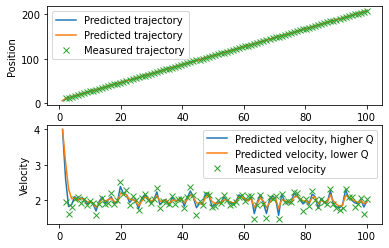

In [3]:
Q = np.array([[0.00033, 0.005],
             [0.005, 0.1]],  dtype='float') #process noise

x_list2, P_list2, K_list2 = EKF(x,P,Q,H,R,zs)
#print(x_list)
x_arr2 = np.array(x_list2)
P_arr2 = np.array(P_list2)
#K_arr = np.array(K_list2)
#print(P_arr)
#print(P_arr[:,0,0])
fig4, (ax5, ax6) = plt.subplots(2)
ax5.plot(time, x_arr[:,0], '-', label = 'Predicted trajectory')
ax5.plot(time, x_arr2[:,0], '-', label = 'Predicted trajectory')
ax5.plot(time[1:], zs[0], 'x', label = 'Measured trajectory')
ax5.legend()
ax5.set_ylabel('Position')
ax6.plot(time, x_arr[:,1], '-', label = 'Predicted velocity, higher Q')
ax6.plot(time, x_arr2[:,1], '-', label = 'Predicted velocity, lower Q')
ax6.plot(time[1:], zs[1], 'x', label = 'Measured velocity')
ax6.legend()
ax6.set_ylabel('Velocity')